# Entity Recognition with LLMs

<div align="left">
<a target="_blank" href="https://console.anyscale.com/"><img src="https://img.shields.io/badge/🚀 Run_on-Anyscale-9hf"></a>&nbsp;
<a href="https://github.com/anyscale/e2e-llm-workflows" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
</div>

Fine-tune an LLM to perform batch inference and online serving for entity recognition. 

<img src="https://raw.githubusercontent.com/anyscale/e2e-llm-workflows/refs/heads/main/images/e2e_llm.png" width=800>

**Note**: the intent of this tutorial is to show how Ray can be use to implement end-to-end LLM workflows that can extend to any use case. Also the objective of fine-tuning here is not to create the most performant model (increase `num_train_epochs` if you want to though) but to show it can be leveraged for downstream workloads (batch inference and online serving) at scale.

## Set up

If you're on [Anyscale](https://console.anyscale.com/), you can run this entire tutorial for free (all dependencies are setup and the necessary compute will autoscale). Otherwise be sure to install the dependencies from the [`containerfile`](containerfile) and provision the appropriate GPU resources (4xA10s).

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/compute.png" width=500>

In [ ]:
import os
os.environ["HF_TOKEN"] = "<INSERT_HF_TOKEN>"  # or use .env

**Note**: Be sure to add your [HuggingFace token](https://huggingface.co/settings/tokens) (`HF_TOKEN=<HF_TOKEN>`) (with access to the model you want to use) and `HF_HUB_ENABLE_HF_TRANSFER=1` (enbales faster uploads and downloads from HF hub) to the *Dependencies* tab.

## Data

In [ ]:
import json
import requests
import textwrap
from IPython.display import Code, Image, display

We'll start by downloading our data from cloud storage to local shared storage. 

In [ ]:
%%bash
rm -rf /mnt/cluster_storage/viggo  # clean up
aws s3 cp  s3://viggo-ds/train.jsonl /mnt/cluster_storage/viggo/
aws s3 cp  s3://viggo-ds/val.jsonl /mnt/cluster_storage/viggo/
aws s3 cp  s3://viggo-ds/test.jsonl /mnt/cluster_storage/viggo/
aws s3 cp  s3://viggo-ds/dataset_info.json /mnt/cluster_storage/viggo/

download: s3://viggo-ds/train.jsonl to ../../../mnt/cluster_storage/viggo/train.jsonl
download: s3://viggo-ds/val.jsonl to ../../../mnt/cluster_storage/viggo/val.jsonl
download: s3://viggo-ds/test.jsonl to ../../../mnt/cluster_storage/viggo/test.jsonl
download: s3://viggo-ds/dataset_info.json to ../../../mnt/cluster_storage/viggo/dataset_info.json


In [ ]:
%%bash
head -n 1 /mnt/cluster_storage/viggo/train.jsonl | python3 -m json.tool

{
    "instruction": "Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values. This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute']. The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']",
    "input": "Blizzard North is mostly an okay developer, but they released Diablo II for the Mac and so that pushes the game from okay to good in my view.",
    "output": "give_opinion(name[Diablo II], developer[Blizzard North], rating[good], has_mac_release[yes])"
}


In [ ]:
with open("/mnt/cluster_storage/viggo/train.jsonl", "r") as fp:
    first_line = fp.readline()
    item = json.loads(first_line)
system_content = item["instruction"]
print(textwrap.fill(system_content, width=80))

Given a target sentence construct the underlying meaning representation of the
input sentence as a single function with attributes and attribute values. This
function should describe the target string accurately and the function must be
one of the following ['inform', 'request', 'give_opinion', 'confirm',
'verify_attribute', 'suggest', 'request_explanation', 'recommend',
'request_attribute']. The attributes must be one of the following: ['name',
'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres',
'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam',
'has_linux_release', 'has_mac_release', 'specifier']


We also have an info file that identifies the datasets and format --- alpaca and sharegpt (great for multimodal tasks) formats are supported --- to use for post training.

In [ ]:
display(Code(filename="/mnt/cluster_storage/viggo/dataset_info.json", language="json"))

{
    "viggo-train": {
        "file_name": "/mnt/cluster_storage/viggo/train.jsonl",
        "formatting": "alpaca",
        "columns": {
            "prompt": "instruction",
            "query": "input",
            "response": "output"
        }
    },
    "viggo-val": {
        "file_name": "/mnt/cluster_storage/viggo/val.jsonl",
        "formatting": "alpaca",
        "columns": {
            "prompt": "instruction",
            "query": "input",
            "response": "output"
        }
    }
}

## Distributed fine-tuning

We'll use [Ray Train](https://docs.ray.io/en/latest/train/train.html) + [LLaMA-Factory](https://github.com/hiyouga/LLaMA-Factory) to peform multinode training. The parameters for our training workload -- post-training method, dataset location, train/val details, etc. --- can be found in the `llama3_lora_sft_ray.yaml` config file. Check out recipes for even more post-training methods (sft, pretraining, ppo, dpo, kto, etc.) [here](https://github.com/hiyouga/LLaMA-Factory/tree/main/examples).

**Note**: We also support using other tools like [axolotl](https://axolotl-ai-cloud.github.io/axolotl/docs/ray-integration.html) or even [Ray Train + HF Accelreate + FSDP/Deepspeed](https://docs.ray.io/en/latest/train/huggingface-accelerate.html) directly for complete control of your post-training workloads.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/distributed_training.png" width=800>

In [ ]:
import os
from pathlib import Path

In [ ]:
display(Code(filename="llama3_lora_sft_ray.yaml", language="yaml"))

### model
model_name_or_path: meta-llama/Meta-Llama-3-8B-Instruct
trust_remote_code: true

### method
stage: sft
do_train: true
finetuning_type: lora
lora_rank: 8
lora_target: all

### dataset
dataset: viggo-train
dataset_dir: /mnt/cluster_storage/viggo  # shared storage workers have access to
template: llama3
cutoff_len: 2048
max_samples: 1000
overwrite_cache: true
preprocessing_num_workers: 16
dataloader_num_workers: 4

### output
output_dir: /mnt/cluster_storage/viggo/outputs  # should be somewhere workers have access to (ex. s3, nfs)
logging_steps: 10
save_steps: 500
plot_loss: true
overwrite_output_dir: true
save_only_model: false

### ray
ray_run_name: llama3_8b_sft_lora
ray_storage_path: /mnt/cluster_storage/viggo/saves  # should be somewhere workers have access to (ex. s3, nfs)
ray_num_workers: 4  # number of GPUs to use
resources_per_worker:
  GPU: 1
placement_strategy: PACK

### train
per_device_train_batch_size: 1
gradient_accumulation_steps: 8
learning_rate: 1.0e-4
num_train_epochs: 3.0
lr_scheduler_type: cosine
warmup_ratio: 0.1
bf16: true
ddp_timeout: 180000000
resume_from_checkpoint: null

### eval
eval_dataset: viggo-val  # uses same dataset_dir as training data
# val_size: 0.1  # only if using part of training data for validation
per_device_eval_batch_size: 1
eval_strategy: steps
eval_steps: 500

In [ ]:
%%bash
# Run multinode distributed fine-tuning workload
USE_RAY=1 llamafactory-cli train llama3_lora_sft_ray.yaml

INFO 04-09 22:55:58 __init__.py:194] No platform detected, vLLM is running on UnspecifiedPlatform


2025-04-09 22:56:01,130	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 10.0.45.206:6379...
2025-04-09 22:56:01,139	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at https://session-zt5t77xa58pyp3uy28glg2g24d.i.anyscaleuserdata.com 
2025-04-09 22:56:01,144	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_ed6c6bcd217058548322bdd912a302ca171a421e.zip' (1.96MiB) to Ray cluster...
2025-04-09 22:56:01,152	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_ed6c6bcd217058548322bdd912a302ca171a421e.zip'.



View detailed results here: /mnt/cluster_storage/viggo/saves/llama3_8b_sft_lora
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-04-09_22-54-49_487486_292703/artifacts/2025-04-09_22-56-02/llama3_8b_sft_lora/driver_artifacts`
(autoscaler +7s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +7s) [autoscaler] Downscaling node i-02b3c66b7ce7a86db (node IP: 10.0.111.111) due to node idle termination.

Training started with configuration:
╭───────────────────────────────────────────────────────────────────────────╮
│ Training config                                                           │
├───────────────────────────────────────────────────────────────────────────┤
│ train_loop_config/args/bf16                                          True │
│ train_loop_config/args/cutoff_len                                    2048 │
│ train_loop_config/args/dataloader_num_workers       

(RayTrainWorker pid=50269, ip=10.0.111.111) Setting up process group for: env:// [rank=0, world_size=4]
(TorchTrainer pid=50157, ip=10.0.111.111) Started distributed worker processes: 
(TorchTrainer pid=50157, ip=10.0.111.111) - (node_id=60601da1390eefd14bfef564c865ae4654f6cb7d86cf019cf75ef9d8, ip=10.0.111.111, pid=50269) world_rank=0, local_rank=0, node_rank=0
(TorchTrainer pid=50157, ip=10.0.111.111) - (node_id=60601da1390eefd14bfef564c865ae4654f6cb7d86cf019cf75ef9d8, ip=10.0.111.111, pid=50270) world_rank=1, local_rank=1, node_rank=0
(TorchTrainer pid=50157, ip=10.0.111.111) - (node_id=60601da1390eefd14bfef564c865ae4654f6cb7d86cf019cf75ef9d8, ip=10.0.111.111, pid=50268) world_rank=2, local_rank=2, node_rank=0
(TorchTrainer pid=50157, ip=10.0.111.111) - (node_id=60601da1390eefd14bfef564c865ae4654f6cb7d86cf019cf75ef9d8, ip=10.0.111.111, pid=50271) world_rank=3, local_rank=3, node_rank=0


(RayTrainWorker pid=50269, ip=10.0.111.111) [WARNING|2025-04-09 22:56:21] llamafactory.hparams.parser:148 >> `ddp_find_unused_parameters` needs to be set as False for LoRA in DDP training.
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|2025-04-09 22:56:21] llamafactory.hparams.parser:379 >> Process rank: 0, world size: 4, device: cuda:0, distributed training: True, compute dtype: torch.bfloat16


(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|tokenization_utils_base.py:2060] 2025-04-09 22:56:22,722 >> loading file tokenizer.json from cache at /home/ray/.cache/huggingface/hub/models--meta-llama--Meta-Llama-3-8B-Instruct/snapshots/5f0b02c75b57c5855da9ae460ce51323ea669d8a/tokenizer.json
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|tokenization_utils_base.py:2060] 2025-04-09 22:56:22,722 >> loading file tokenizer.model from cache at None
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|tokenization_utils_base.py:2060] 2025-04-09 22:56:22,722 >> loading file added_tokens.json from cache at None
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|tokenization_utils_base.py:2060] 2025-04-09 22:56:22,722 >> loading file special_tokens_map.json from cache at /home/ray/.cache/huggingface/hub/models--meta-llama--Meta-Llama-3-8B-Instruct/snapshots/5f0b02c75b57c5855da9ae460ce51323ea669d8a/special_tokens_map.json
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|tokenization_utils_bas

(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|2025-04-09 22:56:24] llamafactory.data.template:143 >> Add pad token: <|eot_id|>
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|2025-04-09 22:56:24] llamafactory.data.template:143 >> Add <|eot_id|>,<|eom_id|> to stop words.
(RayTrainWorker pid=50269, ip=10.0.111.111) [WARNING|2025-04-09 22:56:24] llamafactory.data.template:148 >> New tokens have been added, make sure `resize_vocab` is True.
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|2025-04-09 22:56:24] llamafactory.data.loader:143 >> Loading dataset /mnt/cluster_storage/viggo/train.jsonl...


(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|tokenization_utils_base.py:2323] 2025-04-09 22:56:24,008 >> Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
(RayTrainWorker pid=50269, ip=10.0.111.111) Setting num_proc from 16 back to 1 for the train split to disable multiprocessing as it only contains one shard.
Generating train split: 0 examples [00:00, ? examples/s]
Generating train split: 10206 examples [00:00, 101262.18 examples/s]
Converting format of dataset (num_proc=16): 100%|██████████| 1000/1000 [00:00<00:00, 5292.26 examples/s]


(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|2025-04-09 22:56:24] llamafactory.data.loader:143 >> Loading dataset /mnt/cluster_storage/viggo/val.jsonl...


(RayTrainWorker pid=50269, ip=10.0.111.111) Setting num_proc from 16 back to 1 for the train split to disable multiprocessing as it only contains one shard.
Generating train split: 714 examples [00:00, 101457.91 examples/s]
Running tokenizer on dataset (num_proc=16):  63%|██████▎   | 628/1000 [00:02<00:00, 395.66 examples/s]
(RayTrainWorker pid=50269, ip=10.0.111.111) [rank0]:[W409 22:56:25.918582420 ProcessGroupNCCL.cpp:4115] [PG ID 0 PG GUID 0 Rank 0]  using GPU 0 to perform barrier as devices used by this process are currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect.Specify device_ids in barrier() to force use of a particular device,or call init_process_group() with a device_id. [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
Running tokenizer on da

(RayTrainWorker pid=50269, ip=10.0.111.111) training example:
(RayTrainWorker pid=50269, ip=10.0.111.111) input_ids:
(RayTrainWorker pid=50269, ip=10.0.111.111) [128000, 128006, 882, 128007, 271, 22818, 264, 2218, 11914, 9429, 279, 16940, 7438, 13340, 315, 279, 1988, 11914, 439, 264, 3254, 734, 449, 8365, 323, 7180, 2819, 13, 1115, 734, 1288, 7664, 279, 2218, 925, 30357, 323, 279, 734, 2011, 387, 832, 315, 279, 2768, 2570, 41540, 518, 364, 2079, 518, 364, 47530, 10499, 37400, 518, 364, 14119, 518, 364, 12728, 17209, 518, 364, 96861, 518, 364, 2079, 2769, 36990, 518, 364, 67689, 518, 364, 2079, 17209, 7352, 578, 8365, 2011, 387, 832, 315, 279, 2768, 25, 2570, 609, 518, 364, 4683, 25596, 4257, 518, 364, 23859, 14987, 518, 364, 35501, 518, 364, 288, 10910, 518, 364, 22696, 518, 364, 65011, 518, 364, 3517, 623, 86191, 518, 364, 4752, 26190, 3517, 518, 364, 16111, 82, 518, 364, 10547, 4570, 1284, 14922, 518, 364, 4752, 78563, 25596, 518, 364, 4752, 23647, 25596, 518, 364, 68351, 4532, 5028,

Running tokenizer on dataset (num_proc=16): 100%|██████████| 714/714 [00:03<00:00, 224.77 examples/s]


(RayTrainWorker pid=50269, ip=10.0.111.111) eval example:
(RayTrainWorker pid=50269, ip=10.0.111.111) input_ids:
(RayTrainWorker pid=50269, ip=10.0.111.111) [128000, 128006, 882, 128007, 271, 22818, 264, 2218, 11914, 9429, 279, 16940, 7438, 13340, 315, 279, 1988, 11914, 439, 264, 3254, 734, 449, 8365, 323, 7180, 2819, 13, 1115, 734, 1288, 7664, 279, 2218, 925, 30357, 323, 279, 734, 2011, 387, 832, 315, 279, 2768, 2570, 41540, 518, 364, 2079, 518, 364, 47530, 10499, 37400, 518, 364, 14119, 518, 364, 12728, 17209, 518, 364, 96861, 518, 364, 2079, 2769, 36990, 518, 364, 67689, 518, 364, 2079, 17209, 7352, 578, 8365, 2011, 387, 832, 315, 279, 2768, 25, 2570, 609, 518, 364, 4683, 25596, 4257, 518, 364, 23859, 14987, 518, 364, 35501, 518, 364, 288, 10910, 518, 364, 22696, 518, 364, 65011, 518, 364, 3517, 623, 86191, 518, 364, 4752, 26190, 3517, 518, 364, 16111, 82, 518, 364, 10547, 4570, 1284, 14922, 518, 364, 4752, 78563, 25596, 518, 364, 4752, 23647, 25596, 518, 364, 68351, 4532, 30128, 19

(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|configuration_utils.py:693] 2025-04-09 22:56:34,096 >> loading configuration file config.json from cache at /home/ray/.cache/huggingface/hub/models--meta-llama--Meta-Llama-3-8B-Instruct/snapshots/5f0b02c75b57c5855da9ae460ce51323ea669d8a/config.json
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|configuration_utils.py:765] 2025-04-09 22:56:34,097 >> Model config LlamaConfig {
(RayTrainWorker pid=50269, ip=10.0.111.111)   "architectures": [
(RayTrainWorker pid=50269, ip=10.0.111.111)     "LlamaForCausalLM"
(RayTrainWorker pid=50269, ip=10.0.111.111)   ],
(RayTrainWorker pid=50269, ip=10.0.111.111)   "attention_bias": false,
(RayTrainWorker pid=50269, ip=10.0.111.111)   "attention_dropout": 0.0,
(RayTrainWorker pid=50269, ip=10.0.111.111)   "bos_token_id": 128000,
(RayTrainWorker pid=50269, ip=10.0.111.111)   "eos_token_id": 128009,
(RayTrainWorker pid=50269, ip=10.0.111.111)   "head_dim": 128,
(RayTrainWorker pid=50269, ip=10.0.111.111

(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|2025-04-09 22:56:56] llamafactory.model.model_utils.checkpointing:143 >> Gradient checkpointing enabled.
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|2025-04-09 22:56:56] llamafactory.model.model_utils.attention:143 >> Using torch SDPA for faster training and inference.
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|2025-04-09 22:56:56] llamafactory.model.adapter:143 >> Upcasting trainable params to float32.
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|2025-04-09 22:56:56] llamafactory.model.adapter:143 >> Fine-tuning method: LoRA
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|2025-04-09 22:56:56] llamafactory.model.model_utils.misc:143 >> Found linear modules: k_proj,gate_proj,up_proj,q_proj,v_proj,o_proj,down_proj


(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|configuration_utils.py:1097] 2025-04-09 22:56:56,384 >> loading configuration file generation_config.json from cache at /home/ray/.cache/huggingface/hub/models--meta-llama--Meta-Llama-3-8B-Instruct/snapshots/5f0b02c75b57c5855da9ae460ce51323ea669d8a/generation_config.json
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|configuration_utils.py:1142] 2025-04-09 22:56:56,384 >> Generate config GenerationConfig {
(RayTrainWorker pid=50269, ip=10.0.111.111)   "bos_token_id": 128000,
(RayTrainWorker pid=50269, ip=10.0.111.111)   "do_sample": true,
(RayTrainWorker pid=50269, ip=10.0.111.111)   "eos_token_id": [
(RayTrainWorker pid=50269, ip=10.0.111.111)     128001,
(RayTrainWorker pid=50269, ip=10.0.111.111)     128009
(RayTrainWorker pid=50269, ip=10.0.111.111)   ],
(RayTrainWorker pid=50269, ip=10.0.111.111)   "max_length": 4096,
(RayTrainWorker pid=50269, ip=10.0.111.111)   "temperature": 0.6,
(RayTrainWorker pid=50269, ip=10.0.111.111)   

(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|2025-04-09 22:56:56] llamafactory.model.loader:143 >> trainable params: 20,971,520 || all params: 8,051,232,768 || trainable%: 0.2605


(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|trainer.py:748] 2025-04-09 22:56:56,838 >> Using auto half precision backend
(RayTrainWorker pid=50269, ip=10.0.111.111) [WARNING|trainer.py:783] 2025-04-09 22:56:56,839 >> No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
(RayTrainWorker pid=50271, ip=10.0.111.111) No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|trainer.py:2414] 2025-04-09 22:57:03,221 >> ***** Running training *****
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|trainer.py:2415] 2025-04-09 22:57:03,221 >> 

(RayTrainWorker pid=50269, ip=10.0.111.111) {'loss': 1.7355, 'grad_norm': 1.8911470174789429, 'learning_rate': 9e-05, 'epoch': 0.32}


 22%|██▏       | 20/93 [00:57<03:28,  2.85s/it]) 


(RayTrainWorker pid=50269, ip=10.0.111.111) {'loss': 0.3972, 'grad_norm': 1.3567222356796265, 'learning_rate': 9.712680772628364e-05, 'epoch': 0.64}


 31%|███       | 29/93 [01:22<02:54,  2.72s/it]) 


(RayTrainWorker pid=50269, ip=10.0.111.111) {'loss': 0.1269, 'grad_norm': 0.7699804306030273, 'learning_rate': 8.761797511897906e-05, 'epoch': 0.96}


 43%|████▎     | 40/93 [01:51<02:25,  2.74s/it]) 


(RayTrainWorker pid=50269, ip=10.0.111.111) {'loss': 0.0588, 'grad_norm': 0.4717925190925598, 'learning_rate': 7.278379692281208e-05, 'epoch': 1.26}


 53%|█████▎    | 49/93 [02:16<02:03,  2.80s/it]) 


(RayTrainWorker pid=50269, ip=10.0.111.111) {'loss': 0.0347, 'grad_norm': 0.7581666111946106, 'learning_rate': 5.472425659440157e-05, 'epoch': 1.58}


 63%|██████▎   | 59/93 [02:44<01:36,  2.83s/it]) 


(RayTrainWorker pid=50269, ip=10.0.111.111) {'loss': 0.0244, 'grad_norm': 0.6526265144348145, 'learning_rate': 3.599593228875465e-05, 'epoch': 1.9}


 75%|███████▌  | 70/93 [03:13<01:04,  2.80s/it]) 


(RayTrainWorker pid=50269, ip=10.0.111.111) {'loss': 0.0128, 'grad_norm': 0.7971675395965576, 'learning_rate': 1.9250077799102322e-05, 'epoch': 2.19}


 85%|████████▍ | 79/93 [03:38<00:38,  2.74s/it]) 


(RayTrainWorker pid=50269, ip=10.0.111.111) {'loss': 0.0088, 'grad_norm': 0.112918421626091, 'learning_rate': 6.857300848378856e-06, 'epoch': 2.51}


 96%|█████████▌| 89/93 [04:06<00:11,  2.76s/it]) 


(RayTrainWorker pid=50269, ip=10.0.111.111) {'loss': 0.0131, 'grad_norm': 0.3144412934780121, 'learning_rate': 5.719707204055735e-07, 'epoch': 2.83}


 99%|█████████▉| 92/93 [04:15<00:02,  2.83s/it]) 
(RayTrainWorker pid=50268, ip=10.0.111.111) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/mnt/cluster_storage/viggo/saves/llama3_8b_sft_lora/TorchTrainer_7c0d8_00000_0_2025-04-09_22-56-02/checkpoint_000000)
100%|██████████| 93/93 [04:17<00:00,  2.83s/it][INFO|trainer.py:3984] 2025-04-09 23:01:21,680 >> Saving model checkpoint to /mnt/cluster_storage/viggo/outputs/checkpoint-93
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|configuration_utils.py:693] 2025-04-09 23:01:21,979 >> loading configuration file config.json from cache at /home/ray/.cache/huggingface/hub/models--meta-llama--Meta-Llama-3-8B-Instruct/snapshots/5f0b02c75b57c5855da9ae460ce51323ea669d8a/config.json
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|configuration_utils.py:765] 2025-04-09 23:01:21,979 >> Model config LlamaConfig {
(RayTrainWorker pid=50269, ip=10.0.111.111)   "architectures": [
(RayTrainWorker pid=50269, ip=10.0.111.111)     "


Training finished iteration 1 at 2025-04-09 23:01:26. Total running time: 5min 23s
╭─────────────────────────────────────────╮
│ Training result                         │
├─────────────────────────────────────────┤
│ checkpoint_dir_name   checkpoint_000000 │
│ time_this_iter_s              312.12164 │
│ time_total_s                  312.12164 │
│ training_iteration                    1 │
│ epoch                             2.832 │
│ grad_norm                       0.31444 │
│ learning_rate                        0. │
│ loss                             0.0131 │
│ step                                 90 │
╰─────────────────────────────────────────╯
Training saved a checkpoint for iteration 1 at: (local)/mnt/cluster_storage/viggo/saves/llama3_8b_sft_lora/TorchTrainer_7c0d8_00000_0_2025-04-09_22-56-02/checkpoint_000000


(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|trainer.py:2681] 2025-04-09 23:01:26,580 >> 
(RayTrainWorker pid=50269, ip=10.0.111.111) 
(RayTrainWorker pid=50269, ip=10.0.111.111) Training completed. Do not forget to share your model on huggingface.co/models =)
(RayTrainWorker pid=50269, ip=10.0.111.111) 
(RayTrainWorker pid=50269, ip=10.0.111.111) 


(RayTrainWorker pid=50269, ip=10.0.111.111) {'train_runtime': 263.3559, 'train_samples_per_second': 11.391, 'train_steps_per_second': 0.353, 'train_loss': 0.2595549144691998, 'epoch': 2.93}


100%|██████████| 93/93 [04:22<00:00,  2.83s/it]) 
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|trainer.py:3984] 2025-04-09 23:01:26,692 >> Saving model checkpoint to /mnt/cluster_storage/viggo/outputs
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|configuration_utils.py:693] 2025-04-09 23:01:26,922 >> loading configuration file config.json from cache at /home/ray/.cache/huggingface/hub/models--meta-llama--Meta-Llama-3-8B-Instruct/snapshots/5f0b02c75b57c5855da9ae460ce51323ea669d8a/config.json
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|configuration_utils.py:765] 2025-04-09 23:01:26,922 >> Model config LlamaConfig {
(RayTrainWorker pid=50269, ip=10.0.111.111)   "architectures": [
(RayTrainWorker pid=50269, ip=10.0.111.111)     "LlamaForCausalLM"
(RayTrainWorker pid=50269, ip=10.0.111.111)   ],
(RayTrainWorker pid=50269, ip=10.0.111.111)   "attention_bias": false,
(RayTrainWorker pid=50269, ip=10.0.111.111)   "attention_dropout": 0.0,
(RayTrainWorker pid=50269, ip=10.0.111.

(RayTrainWorker pid=50269, ip=10.0.111.111) ***** train metrics *****
(RayTrainWorker pid=50269, ip=10.0.111.111)   epoch                    =      2.928
(RayTrainWorker pid=50269, ip=10.0.111.111)   total_flos               = 26130810GF
(RayTrainWorker pid=50269, ip=10.0.111.111)   train_loss               =     0.2596
(RayTrainWorker pid=50269, ip=10.0.111.111)   train_runtime            = 0:04:23.35
(RayTrainWorker pid=50269, ip=10.0.111.111)   train_samples_per_second =     11.391
(RayTrainWorker pid=50269, ip=10.0.111.111)   train_steps_per_second   =      0.353
(RayTrainWorker pid=50269, ip=10.0.111.111) Figure saved at: /mnt/cluster_storage/viggo/outputs/training_loss.png
(RayTrainWorker pid=50269, ip=10.0.111.111) [WARNING|2025-04-09 23:01:28] llamafactory.extras.ploting:148 >> No metric eval_viggo-val_loss to plot.
(RayTrainWorker pid=50269, ip=10.0.111.111) [WARNING|2025-04-09 23:01:28] llamafactory.extras.ploting:148 >> No metric eval_viggo-val_accuracy to plot.


(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|trainer.py:4307] 2025-04-09 23:01:28,009 >> 
(RayTrainWorker pid=50269, ip=10.0.111.111) ***** Running Evaluation *****
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|trainer.py:4309] 2025-04-09 23:01:28,009 >>   Num examples = 714
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|trainer.py:4312] 2025-04-09 23:01:28,009 >>   Batch size = 1
 99%|█████████▉| 178/179 [00:19<00:00,  8.84it/s] 


(RayTrainWorker pid=50269, ip=10.0.111.111) ***** eval metrics *****
(RayTrainWorker pid=50269, ip=10.0.111.111)   epoch                             =      2.928
(RayTrainWorker pid=50269, ip=10.0.111.111)   eval_viggo-val_loss               =     0.1033
(RayTrainWorker pid=50269, ip=10.0.111.111)   eval_viggo-val_runtime            = 0:00:19.75
(RayTrainWorker pid=50269, ip=10.0.111.111)   eval_viggo-val_samples_per_second =     36.141
(RayTrainWorker pid=50269, ip=10.0.111.111)   eval_viggo-val_steps_per_second   =      9.061


100%|██████████| 179/179 [00:19<00:00,  9.17it/s] 
(RayTrainWorker pid=50269, ip=10.0.111.111) [INFO|modelcard.py:450] 2025-04-09 23:01:47,829 >> Dropping the following result as it does not have all the necessary fields:
(RayTrainWorker pid=50269, ip=10.0.111.111) {'task': {'name': 'Causal Language Modeling', 'type': 'text-generation'}}



Training completed after 1 iterations at 2025-04-09 23:01:49. Total running time: 5min 46s


2025-04-09 23:01:49,780	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/mnt/cluster_storage/viggo/saves/llama3_8b_sft_lora' in 0.0212s.


<div class="alert alert-block alert"> <b>Ray Train</b> 

Using [Ray Train](https://docs.ray.io/en/latest/train/train.html) here has several advantages:
- automatically handles **multi-node, multi-GPU** setup with no manual SSH setup or hostfile configs. 
- define **per-worker franctional resource requirements** (e.g., 2 CPUs and 0.5 GPU per worker)
- run on **heterogeneous machines** and scale flexibly (e.g., CPU for preprocessing and GPU for training) 
- built-in **fault tolerance** via retry of failed workers (and continue from last checkpoint).
- supports Data Parallel, Model Parallel, Parameter Server, and even custom strategies.
- [Ray Compiled graphs](https://docs.ray.io/en/latest/ray-core/compiled-graph/ray-compiled-graph.html) allow us to even define different parallelism for jointly optimizing multipe models (Megatron, Deepspeed, etc. only allow for one global setting).

[RayTurbo Train](https://docs.anyscale.com/rayturbo/rayturbo-train) offers even more improvement to the price-performance ratio, performance monitoring and more:
- **elastic training** to scale to a dynamic number of workers, continue training on fewer resources (even on spot instances).
- **purpose-built dashboard** designed to streamline the debugging of Ray Train workloads
    - Monitoring: View the status of training runs and train workers.
    - Metrics: See insights on training throughput, training system operation time.
    - Profiling: Investigate bottlenecks, hangs, or errors from individual training worker processes.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/train_dashboard.png" width=700>

<div class="alert alert-block alert"> <b> 🔎 Monitoring and Debugging with Ray</b> 


OSS Ray offers an extensive [observability suite](https://docs.ray.io/en/latest/ray-observability/index.html) that offers logs and an observability dashboard that we can use to monitor and debug. The dashboard includes a lot of different components such as:

-  memory, utilization, etc. of the tasks running in our [cluster](https://docs.ray.io/en/latest/ray-observability/getting-started.html#dash-node-view)

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/cluster_util.png" width=700>

- views to see all our running tasks, utilization across instance types, autoscaling, etc.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/observability_views.png" width=1000>


<div class="alert alert-block alert"> <b> 🔎➕➕ Monitoring and Debugging on Anyscale</b> 

While OSS Ray comes with an extensive obervability suite, Anyscale takes it many steps further to make it even easier and faster to monitor and debug your workloads.

- [unified log viewer](https://docs.anyscale.com/monitoring/accessing-logs/) to see logs from *all* our driver and worker processes
- Ray workload specific dashboard (Data, Train, etc.) that can breakdown the tasks. For example, our training workload above can be observed live through the Train specific Ray Workloads dashboard:

<img src="https://raw.githubusercontent.com/anyscale/e2e-llm-workflows/refs/heads/main/images/train_dashboard.png" width=700>




<div class="alert alert-block alert"> <b> 🗂️ Storage on Anyscale</b> 

We can always store to our data inside [any storage buckets](https://docs.anyscale.com/configuration/storage/#private-storage-buckets) but Anyscale offers a [default storage bucket](https://docs.anyscale.com/configuration/storage/#anyscale-default-storage-bucket) to make things even easier. We also have plenty of other [storage options](https://docs.anyscale.com/configuration/storage/) as well (shared at the cluster, user and cloud levels).

In [ ]:
%%bash
# Anyscale default storage bucket
echo $ANYSCALE_ARTIFACT_STORAGE

s3://anyscale-test-data-cld-i2w99rzq8b6lbjkke9y94vi5/org_7c1Kalm9WcX2bNIjW53GUT/cld_kvedZWag2qA8i5BjxUevf5i7/artifact_storage


In [ ]:
%%bash
# Save fine-tuning artifacts to cloud storage
aws s3 rm $ANYSCALE_ARTIFACT_STORAGE/viggo --recursive --quiet
aws s3 cp /mnt/cluster_storage/viggo/outputs $ANYSCALE_ARTIFACT_STORAGE/viggo/outputs --recursive --quiet
aws s3 cp $2 /mnt/cluster_storage/viggo/saves $ANYSCALE_ARTIFACT_STORAGE/viggo/saves --recursive --quiet

In [ ]:
display(Code(filename="/mnt/cluster_storage/viggo/outputs/all_results.json", language="json"))

{
    "epoch": 2.928,
    "eval_viggo-val_loss": 0.1033112108707428,
    "eval_viggo-val_runtime": 19.7559,
    "eval_viggo-val_samples_per_second": 36.141,
    "eval_viggo-val_steps_per_second": 9.061,
    "total_flos": 2.805774446441267e+16,
    "train_loss": 0.2595549144691998,
    "train_runtime": 263.3559,
    "train_samples_per_second": 11.391,
    "train_steps_per_second": 0.353
}

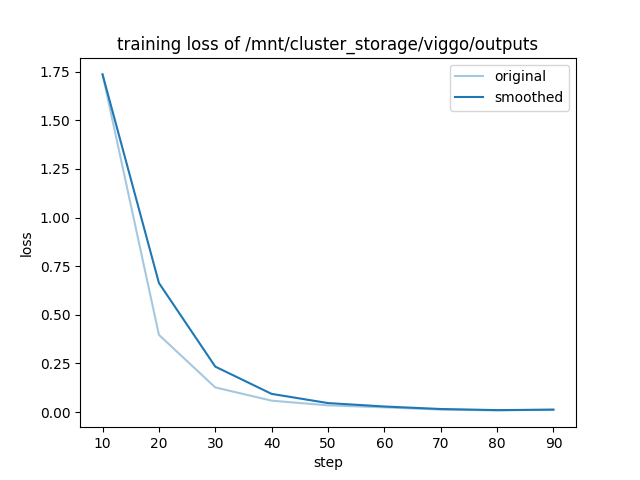

In [ ]:
display(Image(filename="/mnt/cluster_storage/viggo/outputs/training_loss.png"))

In [ ]:
%%bash
ls /mnt/cluster_storage/viggo/saves/llama3_8b_sft_lora

TorchTrainer_7c0d8_00000_0_2025-04-09_22-56-02
basic-variant-state-2025-04-09_22-56-02.json
experiment_state-2025-04-09_22-56-02.json
trainer.pkl
tuner.pkl


In [ ]:
# LoRA paths
save_dir = Path("/mnt/cluster_storage/viggo/saves/llama3_8b_sft_lora")
trainer_dirs = [d for d in save_dir.iterdir() if d.name.startswith("TorchTrainer_") and d.is_dir()]
latest_trainer = max(trainer_dirs, key=lambda d: d.stat().st_mtime, default=None)
lora_path = f"{latest_trainer}/checkpoint_000000/checkpoint"
s3_lora_path = os.path.join(os.getenv("ANYSCALE_ARTIFACT_STORAGE"), lora_path.split("/mnt/cluster_storage/")[-1])
dynamic_lora_path, lora_id = s3_lora_path.rsplit("/", 1)
print (lora_path)
print (s3_lora_path)
print (dynamic_lora_path)
print (lora_id)

/mnt/cluster_storage/viggo/saves/llama3_8b_sft_lora/TorchTrainer_7c0d8_00000_0_2025-04-09_22-56-02/checkpoint_000000/checkpoint
s3://anyscale-test-data-cld-i2w99rzq8b6lbjkke9y94vi5/org_7c1Kalm9WcX2bNIjW53GUT/cld_kvedZWag2qA8i5BjxUevf5i7/artifact_storage/viggo/saves/llama3_8b_sft_lora/TorchTrainer_7c0d8_00000_0_2025-04-09_22-56-02/checkpoint_000000/checkpoint
s3://anyscale-test-data-cld-i2w99rzq8b6lbjkke9y94vi5/org_7c1Kalm9WcX2bNIjW53GUT/cld_kvedZWag2qA8i5BjxUevf5i7/artifact_storage/viggo/saves/llama3_8b_sft_lora/TorchTrainer_7c0d8_00000_0_2025-04-09_22-56-02/checkpoint_000000
checkpoint


In [ ]:
%%bash -s "$lora_path"
ls $1

README.md
adapter_config.json
adapter_model.safetensors
optimizer.pt
rng_state_0.pth
rng_state_1.pth
rng_state_2.pth
rng_state_3.pth
scheduler.pt
special_tokens_map.json
tokenizer.json
tokenizer_config.json
trainer_state.json
training_args.bin


## Batch inference 
[`Overview`](https://docs.ray.io/en/latest/data/working-with-llms.html) |  [`API reference`](https://docs.ray.io/en/latest/data/api/llm.html)

The `ray.data.llm` module integrates with key large language model (LLM) inference engines and deployed models to enable LLM batch inference. These llm modules use [Ray Data](https://docs.ray.io/en/latest/data/data.html) under the hood, which makes it extremely easy to distribute our workloads but also ensures that they happen:
- **efficiently**: minimize CPU/GPU idletime with hetergenous resource scheduling.
- **at scale**: streaming execution to petabyte-scale datasets (especially when [working with LLMs](https://docs.ray.io/en/latest/data/working-with-llms.html))
- **reliably** by checkpointing processes, especially when running workloads on spot instanes (with on-demand fallback).
- **flexiblibly**: connect to data from any source, apply your transformations and save to any format/location for your next workload.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/ray_data_solution.png" width=800>

[RayTurbo Data](https://docs.anyscale.com/rayturbo/rayturbo-data) has even more functionality on top of Ray Data:
- **accelerated metadata fetching** to improve reading first time from large datasets 
- **optimized autoscaling** where Jobs can kick off before waiting for the entire cluster to start
- **high reliabilty** where entire fails jobs (head node, cluster, uncaptured exceptions, etc.) can resume from checkpoints (OSS Ray can only recover from worker node failures)

Let's start by defining the [vLLM engine processor config](https://docs.ray.io/en/latest/data/api/doc/ray.data.llm.vLLMEngineProcessorConfig.html#ray.data.llm.vLLMEngineProcessorConfig) where we can select the model we want to use and the [engine behavior](https://docs.vllm.ai/en/stable/serving/engine_args.html). The model can come from [HuggingFace (HF) Hub](https://huggingface.co/models) or a local model path `/path/to/your/model` (GPTQ, GGUF, or LoRA model formats supported).

<img src="https://raw.githubusercontent.com/anyscale/e2e-llm-workflows/refs/heads/main/images/data_llm.png" width=800>

In [ ]:
import os
import ray
from ray.data.llm import vLLMEngineProcessorConfig, build_llm_processor
import numpy as np

INFO 04-09 23:02:04 __init__.py:194] No platform detected, vLLM is running on UnspecifiedPlatform


In [ ]:
config = vLLMEngineProcessorConfig(
    model_source="meta-llama/Meta-Llama-3-8B-Instruct",
    runtime_env={"env_vars": {"HF_TOKEN": os.environ.get("HF_TOKEN")}},
    engine_kwargs={
        "enable_lora": True,
        "max_lora_rank": 8,
        "max_loras": 1,
        "pipeline_parallel_size": 1, 
        "tensor_parallel_size": 1,
        "enable_prefix_caching": True,
        "enable_chunked_prefill": True,
        "max_num_batched_tokens": 4096,
        # complete list: https://docs.vllm.ai/en/stable/serving/engine_args.html
    },
    concurrency=1,
    batch_size=16,
    accelerator_type="A10G",
)

Next, we'll pass our config to an [llm processor](https://docs.ray.io/en/master/data/api/doc/ray.data.llm.build_llm_processor.html#ray.data.llm.build_llm_processor) where we can define the preprocessing and postprocessing steps around inference. With our base model defined in the processor config, we can define the lora adapter layers as part of the preprocessing step of the llm processor itself.

In [ ]:
processor = build_llm_processor(
    config,
    preprocess=lambda row: dict(
        model=lora_path,  # REMOVE this line if doing inference with just the base model
        messages=[
            {"role": "system", "content": system_content},
            {"role": "user", "content": row["input"]}
        ],
        sampling_params={
            "temperature": 0.3,
            "max_tokens": 250,
            # complete list: https://docs.vllm.ai/en/stable/api/inference_params.html
        },
    ),
    postprocess=lambda row: {
        **row,  # all contents
        "generated_output": row["generated_text"],
        # add additional outputs
    },
)

2025-04-09 23:02:05,172	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 10.0.45.206:6379...
2025-04-09 23:02:05,182	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at https://session-zt5t77xa58pyp3uy28glg2g24d.i.anyscaleuserdata.com 
2025-04-09 23:02:05,188	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_e0c21ef4701e68218e82c96d1812778e1ee8b5c9.zip' (2.01MiB) to Ray cluster...
2025-04-09 23:02:05,197	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_e0c21ef4701e68218e82c96d1812778e1ee8b5c9.zip'.


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

(pid=303109) INFO 04-09 23:02:11 __init__.py:194] No platform detected, vLLM is running on UnspecifiedPlatform


In [ ]:
# Evaluation on test dataset
ds = ray.data.read_json("/mnt/cluster_storage/viggo/test.jsonl")  # complete list: https://docs.ray.io/en/latest/data/api/input_output.html
ds = processor(ds)
results = ds.take_all()
results[0]

2025-04-09 23:02:20,279	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-04-09_22-54-49_487486_292703/logs/ray-data
2025-04-09 23:02:20,280	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> ActorPoolMapOperator[Map(_preprocess)->MapBatches(ChatTemplateUDF)] -> ActorPoolMapOperator[MapBatches(TokenizeUDF)] -> ActorPoolMapOperator[MapBatches(vLLMEngineStageUDF)] -> ActorPoolMapOperator[MapBatches(DetokenizeUDF)] -> TaskPoolMapOperator[Map(_postprocess)]


Running 0: 0.00 row [00:00, ? row/s]

(_MapWorker pid=53538, ip=10.0.111.111) INFO 04-09 23:02:25 __init__.py:190] Automatically detected platform cuda.
(_MapWorker pid=53630, ip=10.0.111.111) INFO 04-09 23:02:33 __init__.py:190] Automatically detected platform cuda.
(_MapWorker pid=53717, ip=10.0.111.111) INFO 04-09 23:02:39 __init__.py:190] Automatically detected platform cuda.


(_MapWorker pid=53717, ip=10.0.111.111) Max pending requests is set to 141


(_MapWorker pid=53717, ip=10.0.111.111) INFO 04-09 23:02:48 config.py:1556] Chunked prefill is enabled with max_num_batched_tokens=4096.
(_MapWorker pid=53717, ip=10.0.111.111) WARNING 04-09 23:02:48 config.py:2162] LoRA with chunked prefill is still experimental and may be unstable.
(_MapWorker pid=53717, ip=10.0.111.111) INFO 04-09 23:02:48 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='meta-llama/Meta-Llama-3-8B-Instruct', speculative_config=None, tokenizer='meta-llama/Meta-Llama-3-8B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), obs

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  6.50it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:00<00:00,  2.04it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  1.49it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.31it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.49it/s]
(_MapWorker pid=53717, ip=10.0.111.111) 


(_MapWorker pid=53717, ip=10.0.111.111) INFO 04-09 23:02:54 model_runner.py:1115] Loading model weights took 14.9634 GB
(_MapWorker pid=53717, ip=10.0.111.111) INFO 04-09 23:02:54 punica_selector.py:18] Using PunicaWrapperGPU.
(_MapWorker pid=53717, ip=10.0.111.111) INFO 04-09 23:03:02 worker.py:267] Memory profiling takes 7.10 seconds
(_MapWorker pid=53717, ip=10.0.111.111) INFO 04-09 23:03:02 worker.py:267] the current vLLM instance can use total_gpu_memory (21.99GiB) x gpu_memory_utilization (0.90) = 19.79GiB
(_MapWorker pid=53717, ip=10.0.111.111) INFO 04-09 23:03:02 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.06GiB; PyTorch activation peak memory takes 1.21GiB; the rest of the memory reserved for KV Cache is 3.56GiB.
(_MapWorker pid=53717, ip=10.0.111.111) INFO 04-09 23:03:02 executor_base.py:110] # CUDA blocks: 1824, # CPU blocks: 2048
(_MapWorker pid=53717, ip=10.0.111.111) INFO 04-09 23:03:02 executor_base.py:115] Maximum concurrency for 8192 tokens per

Capturing CUDA graph shapes:  63%|██████▎   | 22/35 [00:12<00:06,  1.87it/s]


Capturing CUDA graph shapes:  97%|█████████▋| 34/35 [00:19<00:00,  1.88it/s]


(_MapWorker pid=53717, ip=10.0.111.111) INFO 04-09 23:03:25 model_runner.py:1562] Graph capturing finished in 20 secs, took 0.41 GiB
(_MapWorker pid=53717, ip=10.0.111.111) INFO 04-09 23:03:25 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 30.26 seconds


Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:19<00:00,  1.77it/s]


(_MapWorker pid=53998, ip=10.0.111.111) INFO 04-09 23:03:30 __init__.py:190] Automatically detected platform cuda.


- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- Map(_preprocess)->MapBatches(ChatTemplateUDF) 3: 0.00 row [00:00, ? row/s]

- MapBatches(TokenizeUDF) 4: 0.00 row [00:00, ? row/s]

- MapBatches(vLLMEngineStageUDF) 5: 0.00 row [00:00, ? row/s]

- MapBatches(DetokenizeUDF) 6: 0.00 row [00:00, ? row/s]

- Map(_postprocess) 7: 0.00 row [00:00, ? row/s]

(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) INFO 04-09 23:03:39 metrics.py:455] Avg prompt throughput: 281.2 tokens/s, Avg generation throughput: 1.5 tokens/s, Running: 125 reqs, Swapped: 0 reqs, Pending: 16 reqs, GPU KV cache usage: 20.4%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) INFO 04-09 23:03:39 metrics.py:471] Prefix cache hit rate: GPU: 81.47%, CPU: 0.00%
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) INFO 04-09 23:03:44 metrics.py:455] Avg prompt throughput: 4402.7 tokens/s, Avg generation throughput: 276.5 tokens/s, Running: 141 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 27.0%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) INFO 04-09 23:03:44 metrics.py:471] Prefix cache hit rate: GPU: 82.24%, CPU: 0.00%


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 918285b1c45b4b7fa55bf41bc9d746e9 with size 16: 10.353171740000107
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 91bcb4a8b2054f698fe5e16cc80039d8 with size 16: 10.35420935899674
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 4a758f7d3e8e40049454fb3ae9fcc414 with size 16: 10.52400933899844
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 011f885727804abfa79ab9fdadee641c with size 16: 11.27964028200222
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch fb932d03f4ef465c97d4dce75146f156 with size 16: 11.612004564998642


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) INFO 04-09 23:03:49 metrics.py:455] Avg prompt throughput: 5891.5 tokens/s, Avg generation throughput: 1017.6 tokens/s, Running: 138 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 33.1%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) INFO 04-09 23:03:49 metrics.py:471] Prefix cache hit rate: GPU: 81.66%, CPU: 0.00%


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 9f065c7eddbc42f492ae8d94f3791d39 with size 16: 13.161949983998056
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 9aa1c739ff714a4b8999503722112468 with size 16: 13.162136987997656
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 18dcff6c9557456fbe745622ad076e2c with size 16: 13.309402849001344
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch a832e44f9dda4c5fa0ba6c6b8a3f809b with size 16: 13.456944176999968
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 8369f84131dc4cf7a868237ab234a178 with size 16: 14.080507365000813
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 3b9983ff7ae94b498740293f01fbca6e with size 16: 14.478418546998
(

(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) INFO 04-09 23:03:54 metrics.py:455] Avg prompt throughput: 6374.7 tokens/s, Avg generation throughput: 941.3 tokens/s, Running: 132 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 30.1%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) INFO 04-09 23:03:54 metrics.py:471] Prefix cache hit rate: GPU: 82.11%, CPU: 0.00%


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 7f88663ef776484484f71e6d20c2e665 with size 16: 17.43080458699842
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 6b6e54c838574ef294bff43c0575a7ea with size 16: 17.59420379600124
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch e451ee6222994393a1f8501d97fa2254 with size 16: 18.418407609002315
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 60939a8c03bf4e319c6e7a11a1073569 with size 16: 18.76322501300092
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 1631ea3f566e4aae8f204a33ccc121ef with size 16: 18.763804492999043
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch ef47abfd955f4679bd47be8d733c7538 with size 16: 19.08219602999816
(M

(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) INFO 04-09 23:04:00 metrics.py:455] Avg prompt throughput: 6131.1 tokens/s, Avg generation throughput: 1005.2 tokens/s, Running: 131 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 30.9%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) INFO 04-09 23:04:00 metrics.py:471] Prefix cache hit rate: GPU: 82.52%, CPU: 0.00%


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch f84703ab73e140f9a8f386676f03afcc with size 16: 23.687944266999693
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 7f286b1310494d239593747a89d6bc33 with size 16: 23.688687339999888
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 908e354b12a34310bec4b6d5d0d80d89 with size 16: 23.68880353199711
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 290bec265b1b41a4a817cbbe06262cb7 with size 16: 23.68863207800314
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 9feadbd8e9734922a9e651a4baa105b4 with size 16: 24.038543991999177
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 9df3e0c059654316ba035ff27361dfb9 with size 16: 24.039294924998103


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) INFO 04-09 23:04:05 metrics.py:455] Avg prompt throughput: 6692.4 tokens/s, Avg generation throughput: 987.6 tokens/s, Running: 135 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 28.9%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) INFO 04-09 23:04:05 metrics.py:471] Prefix cache hit rate: GPU: 82.80%, CPU: 0.00%


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch df106911d2604c38b1bdb2046500abf7 with size 16: 28.46336634399995
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch f961ae8d9c1440229e9342d6420ec31e with size 16: 28.566756658001395
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 2c8fe5cb387e43489e3ec32ff102d9e8 with size 16: 28.66843572200014
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 130ab95af6f646f0a76155491532589e with size 16: 29.274612645996967
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch b1c77f95e6674d90b8ea814d469e165b with size 16: 30.057514157997502
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 6ec035d3f27e42409602409dfafbd6eb with size 16: 30.30578209899977
(

(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) INFO 04-09 23:04:10 metrics.py:455] Avg prompt throughput: 6996.9 tokens/s, Avg generation throughput: 929.7 tokens/s, Running: 136 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 30.7%, CPU KV cache usage: 0.0%.
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) INFO 04-09 23:04:10 metrics.py:471] Prefix cache hit rate: GPU: 82.76%, CPU: 0.00%


(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 0bfff9d30cc948979cf4a6707cf77e29 with size 16: 34.58387783500075
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch ee17ffce1d384760af11c0ab16438dd4 with size 16: 35.02139270399857
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch a4bc15f5591f48978bc5c630d9431aa5 with size 16: 35.09346866600026
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 8431076551b14a36983333d133bf5152 with size 16: 35.230802549001965
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch 2f623997af0547278d8aaa254410e878 with size 16: 35.231007022000995
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=53717, ip=10.0.111.111) [vLLM] Elapsed time for batch c2d8f3fbf07d418bacacf39aef772c15 with size 16: 35.36496385600185
(M

{'batch_uuid': '8369f84131dc4cf7a868237ab234a178',
 'embeddings': None,
 'generated_text': 'request(specifier[weirdest])',
 'generated_tokens': [2079, 39309, 3125, 58, 906, 404, 5086, 2526, 128009],
 'input': "What do you think is the weirdest game you've ever played?",
 'instruction': "Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values. This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute']. The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']",
 'messages': [{'content': "Given a target sentence con

In [ ]:
# Exact match (strict!)
matches = 0
for item in results:
    if item["output"] == item["generated_output"]:
        matches += 1
matches / float(len(results))

0.7571560480147738

And of course, we can observe the individual steps in our our batch inference workload through the Anyscale Ray Data dashboard:

<img src="https://raw.githubusercontent.com/anyscale/e2e-llm-workflows/refs/heads/main/images/data_dashboard.png" width=1000>

<div class="alert alert-info">

💡 For more advanced guides on topics like optimized model loading, multi-lora, openai-compatible endpoints, etc. check out [more examples](https://docs.ray.io/en/latest/data/working-with-llms.html) and the [API reference](https://docs.ray.io/en/latest/data/api/llm.html).

</div>

## Online serving
[`Overview`](https://docs.ray.io/en/latest/serve/llm/serving-llms.html) | [`API reference`](https://docs.ray.io/en/latest/serve/api/index.html#llm-api)

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/ray_serve.png" width=600>

`ray.serve.llm` APIs allow users to deploy multiple LLM models together with a familiar Ray Serve API, while providing compatibility with the OpenAI API.

<img src="https://raw.githubusercontent.com/anyscale/e2e-llm-workflows/refs/heads/main/images/serve_llm.png" width=500>

Ray Serve LLM is designed with the following features:
- Automatic scaling and load balancing
- Unified multi-node multi-model deployment
- OpenAI compatibility
- Multi-LoRA support with shared base models
- Deep integration with inference engines (vLLM to start)
- Composable multi-model LLM pipelines

[RayTurbo Serve](https://docs.anyscale.com/rayturbo/rayturbo-serve) on Anyscale has even more functionality on top of Ray Serve:
- **fast autoscaling and model loading** to get our services up and running even faster ([5x improvements](https://www.anyscale.com/blog/autoscale-large-ai-models-faster) even for LLMs)
- 54% **higher QPS** and up-to 3x **streaming tokens per second** for high traffic serving use-cases
- **replica compaction** into fewer nodes where possible to reduce resource fragmentation and improve hardware utilization
- **zero-downtime** [incremental rollouts](https://docs.anyscale.com/platform/services/update-a-service/#resource-constrained-updates) so your service is never interrupted
- [**different environments**](https://docs.anyscale.com/platform/services/multi-app/#multiple-applications-in-different-containers) for each service in a multi-serve application
- **multi availability-zone** aware scheduling of Ray Serve replicas to provide higher redundancy to availability zone failures


In [ ]:
import os
from openai import OpenAI  # to use openai api format
from ray import serve
from ray.serve.llm import LLMConfig, build_openai_app

Let's define an [LLM config](https://docs.ray.io/en/latest/serve/api/doc/ray.serve.llm.LLMConfig.html#ray.serve.llm.LLMConfig) where we can define where our model comes from, it's [autoscaling behavior](https://docs.ray.io/en/latest/serve/autoscaling-guide.html#serve-autoscaling), what hardware to use and [engine arguments](https://docs.vllm.ai/en/stable/serving/engine_args.html).

In [ ]:
# Define config
model_id = "llama-3-8b-instruct"  # call it whatever you want
model_source = "meta-llama/Meta-Llama-3-8B-Instruct"  # HF model ID, S3 mirror config, or GCS mirror config
llm_config = LLMConfig(
    model_loading_config={
        "model_id": model_id,
        "model_source": model_source
    },
    lora_config={  # REMOVE this section if you are only using a base model
        "dynamic_lora_loading_path": dynamic_lora_path,
        "max_num_adapters_per_replica": 16,  # we only have 1
    },
    runtime_env={"env_vars": {"HF_TOKEN": os.environ.get("HF_TOKEN")}},
    deployment_config={
        "autoscaling_config": {
            "min_replicas": 1, 
            "max_replicas": 2,
            # complete list: https://docs.ray.io/en/latest/serve/autoscaling-guide.html#serve-autoscaling
        }
    },
    accelerator_type="A10G",
    engine_kwargs={
        "tensor_parallel_size": 1,
        "enable_lora": True,
        # complete list: https://docs.vllm.ai/en/stable/serving/engine_args.html
    },
)

Now we'll deploy our llm config as an application. And since this is all built on top of [Ray Serve](https://docs.ray.io/en/latest/serve/index.html), we can have advanvced service logic around composing models together, deploying multiple applications, model multiplexing, observability, etc.

In [ ]:
# Deploy
app = build_openai_app({"llm_configs": [llm_config]})
serve.run(app)

INFO 2025-04-09 23:04:38,444 serve 300688 -- Started Serve in namespace "serve".
(ServeController pid=303792) INFO 2025-04-09 23:04:38,457 controller 303792 -- Deploying new version of Deployment(name='LLMDeployment:llama-3-8b-instruct', app='default') (initial target replicas: 1).
(ServeController pid=303792) INFO 2025-04-09 23:04:38,458 controller 303792 -- Deploying new version of Deployment(name='LLMRouter', app='default') (initial target replicas: 2).
(ProxyActor pid=303855) INFO 2025-04-09 23:04:38,364 proxy 10.0.45.206 -- Proxy starting on node 375cb438a81c8af7ab75ca4792b317278a709f4ea793eac6b4ddd264 (HTTP port: 8000).
(ProxyActor pid=303855) INFO 2025-04-09 23:04:38,412 proxy 10.0.45.206 -- Got updated endpoints: {}.
(ProxyActor pid=303855) INFO 2025-04-09 23:04:38,461 proxy 10.0.45.206 -- Got updated endpoints: {Deployment(name='LLMRouter', app='default'): EndpointInfo(route='/', app_is_cross_language=False)}.
(ServeController pid=303792) INFO 2025-04-09 23:04:38,562 controlle

(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) INFO 04-09 23:04:43 __init__.py:190] Automatically detected platform cuda.


(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) INFO 2025-04-09 23:04:44,746 default_LLMDeployment:llama-3-8b-instruct vllfluch -- No cloud storage mirror configured
(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) INFO 2025-04-09 23:04:44,746 default_LLMDeployment:llama-3-8b-instruct vllfluch -- Downloading the tokenizer for meta-llama/Meta-Llama-3-8B-Instruct
(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) You are using a model of type llama to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) You are using a model of type llama to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
(ProxyActor pid=54413, ip=10.0.111.111) INFO 2025-04-09 23:04:45,652 proxy 10.0.111.111 -- Proxy starting

(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) INFO 04-09 23:04:54 config.py:542] This model supports multiple tasks: {'embed', 'classify', 'score', 'generate', 'reward'}. Defaulting to 'generate'.
(ServeReplica:default:LLMRouter pid=54415, ip=10.0.111.111) INFO 04-09 23:04:44 __init__.py:190] Automatically detected platform cuda. [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) INFO 2025-04-09 23:04:55,162 default_LLMDeployment:llama-3-8b-instruct vllfluch -- [STATUS] Getting the server ready ...


(pid=54924, ip=10.0.111.111) INFO 04-09 23:05:00 __init__.py:190] Automatically detected platform cuda.


(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 2025-04-09 23:05:00,840 serve 54924 -- Clearing the current platform cache ...


(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 04-09 23:05:00 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='meta-llama/Meta-Llama-3-8B-Instruct', speculative_config=None, tokenizer='meta-llama/Meta-Llama-3-8B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=meta-llama/Meta-Llama-3-8B-Instruct, num_scheduler_steps=1, multi_step_stream_outputs=True, enable_prefix_cachi

(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) Connecting to existing Ray cluster at address: 10.0.45.206:6379...
(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) Calling ray.init() again after it has already been called.


(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 04-09 23:05:01 ray_distributed_executor.py:149] use_ray_spmd_worker: False


(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) INFO 2025-04-09 23:05:05,212 default_LLMDeployment:llama-3-8b-instruct vllfluch -- [STATUS] Waiting for engine process ...


(pid=55013, ip=10.0.111.111) INFO 04-09 23:05:06 __init__.py:190] Automatically detected platform cuda.
(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 04-09 23:05:08 cuda.py:230] Using Flash Attention backend.


(ServeController pid=303792) WARNING 2025-04-09 23:05:08,652 controller 303792 -- Deployment 'LLMDeployment:llama-3-8b-instruct' in application 'default' has 1 replicas that have taken more than 30s to initialize.
(ServeController pid=303792) This may be caused by a slow __init__ or reconfigure method.
(ServeController pid=303792) WARNING 2025-04-09 23:05:08,653 controller 303792 -- Deployment 'LLMRouter' in application 'default' has 2 replicas that have taken more than 30s to initialize.
(ServeController pid=303792) This may be caused by a slow __init__ or reconfigure method.


(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 04-09 23:05:09 model_runner.py:1110] Starting to load model meta-llama/Meta-Llama-3-8B-Instruct...
(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 04-09 23:05:09 weight_utils.py:252] Using model weights format ['*.safetensors']


Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:00<00:00,  6.54it/s]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:00<00:00,  2.06it/s]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:01<00:00,  1.50it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.32it/s]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:02<00:00,  1.51it/s]
(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) 


(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 04-09 23:05:12 model_runner.py:1115] Loading model weights took 14.9634 GB
(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 04-09 23:05:12 punica_selector.py:18] Using PunicaWrapperGPU.


(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) INFO 2025-04-09 23:05:16,263 default_LLMDeployment:llama-3-8b-instruct vllfluch -- [STATUS] Waiting for engine process ...


(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 04-09 23:05:18 worker.py:267] Memory profiling takes 5.97 seconds
(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 04-09 23:05:18 worker.py:267] the current vLLM instance can use total_gpu_memory (21.99GiB) x gpu_memory_utilization (0.90) = 19.79GiB
(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 04-09 23:05:18 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.06GiB; PyTorch activation peak memory takes 1.24GiB; the rest of the memory reserved for KV Cache is 3.53GiB.
(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 04-09 23:05:19 executor_base.py:110] # CUDA blocks: 1808, # CPU blocks: 2048
(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 04-09 23:05:19 executor_base.py:115] Maximum concurrency for 8192 tokens per request: 3.53x


Capturing CUDA graph shapes:   0%|          | 0/35 [00:00<?, ?it/s]


(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 04-09 23:05:22 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.


Capturing CUDA graph shapes:  20%|██        | 7/35 [00:04<00:17,  1.60it/s]
(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) INFO 2025-04-09 23:05:27,315 default_LLMDeployment:llama-3-8b-instruct vllfluch -- [STATUS] Waiting for engine process ...
Capturing CUDA graph shapes:  77%|███████▋  | 27/35 [00:15<00:04,  1.80it/s]
(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) INFO 2025-04-09 23:05:38,359 default_LLMDeployment:llama-3-8b-instruct vllfluch -- [STATUS] Waiting for engine process ...
Capturing CUDA graph shapes:  80%|████████  | 28/35 [00:16<00:03,  1.81it/s]
(ServeController pid=303792) WARNING 2025-04-09 23:05:38,728 controller 303792 -- Deployment 'LLMDeployment:llama-3-8b-instruct' in application 'default' has 1 replicas that have taken more than 30s to initialize.
(ServeController pid=303792) This may be caused by a slow __init__ or reconfigure method.
(ServeController pid=303792) WARNING 2025-04-09 23:0

(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 04-09 23:05:42 model_runner.py:1562] Graph capturing finished in 20 secs, took 0.41 GiB
(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 04-09 23:05:42 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 29.69 seconds


(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) INFO 2025-04-09 23:05:42,645 default_LLMDeployment:llama-3-8b-instruct vllfluch -- [STATUS] Server is ready.
(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) INFO 2025-04-09 23:05:42,645 default_LLMDeployment:llama-3-8b-instruct vllfluch -- Started vLLM engine.


(raylet) WARNING: 4 PYTHON worker processes have been started on node: 375cb438a81c8af7ab75ca4792b317278a709f4ea793eac6b4ddd264 with address: 10.0.45.206. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
(pid=304273) INFO 04-09 23:05:49 __init__.py:194] No platform detected, vLLM is running on UnspecifiedPlatform


(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) INFO 2025-04-09 23:05:50,345 default_LLMDeployment:llama-3-8b-instruct vllfluch 34974a51-acd9-4696-b485-52c948100833 -- CALL llm_config OK 300.6ms
(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) INFO 2025-04-09 23:05:50,351 default_LLMDeployment:llama-3-8b-instruct vllfluch 2f5142ec-0a45-45c7-88a4-f80ded7c39bd -- CALL llm_config OK 305.4ms
INFO 2025-04-09 23:05:51,701 serve 300688 -- Application 'default' is ready at http://127.0.0.1:8000/.
INFO 2025-04-09 23:05:51,708 serve 300688 -- Started <ray.serve._private.router.SharedRouterLongPollClient object at 0x767d1c0dd760>.


DeploymentHandle(deployment='LLMRouter')

In [ ]:
# Initialize client
client = OpenAI(base_url="http://localhost:8000/v1", api_key="fake-key")
response = client.chat.completions.create(
    model=f"{model_id}:{lora_id}",
    messages=[
        {"role": "system", "content": "Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values. This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute']. The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']"},
        {"role": "user", "content": "Blizzard North is mostly an okay developer, but they released Diablo II for the Mac and so that pushes the game from okay to good in my view."},
    ],
    stream=True
)
for chunk in response:
    if chunk.choices[0].delta.content is not None:
        print(chunk.choices[0].delta.content, end="", flush=True)

(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) INFO 2025-04-09 23:06:28,939 default_LLMDeployment:llama-3-8b-instruct vllfluch 4f3bbf11-2236-4268-80bc-3fdc928c86fa -- Received streaming request 4f3bbf11-2236-4268-80bc-3fdc928c86fa
(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) INFO 2025-04-09 23:06:28,940 default_LLMDeployment:llama-3-8b-instruct vllfluch 4f3bbf11-2236-4268-80bc-3fdc928c86fa -- Request 4f3bbf11-2236-4268-80bc-3fdc928c86fa started. Prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>
(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) 
(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values. This function should describe the target string accurately and the function must be 

(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 04-09 23:06:28 engine.py:275] Added request 4f3bbf11-2236-4268-80bc-3fdc928c86fa.
(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 04-09 23:06:29 metrics.py:455] Avg prompt throughput: 24.2 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
give_opinion(name[Diablo II], developer[Blizzard North], rating[good], has_mac_release[yes])

(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 04-09 23:06:29 engine.py:293] Aborted request 4f3bbf11-2236-4268-80bc-3fdc928c86fa.


(ServeReplica:default:LLMRouter pid=54414, ip=10.0.111.111) INFO 2025-04-09 23:06:29,896 default_LLMRouter md1yf1gj 4f3bbf11-2236-4268-80bc-3fdc928c86fa -- POST /v1/chat/completions 200 964.8ms
(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) INFO 2025-04-09 23:06:29,892 default_LLMDeployment:llama-3-8b-instruct vllfluch 4f3bbf11-2236-4268-80bc-3fdc928c86fa -- Request 4f3bbf11-2236-4268-80bc-3fdc928c86fa finished (stop). Total time: 0.9516414559984696s, Queue time: 0.0012445449829101562s, Generation+async time: 0.9503969110155595s, Input tokens: 187, Generated tokens: 26, tokens/s: 224.11689003954777, generated tokens/s: 27.35699127243306.
(ServeReplica:default:LLMDeployment:llama-3-8b-instruct pid=54412, ip=10.0.111.111) INFO 2025-04-09 23:06:29,893 default_LLMDeployment:llama-3-8b-instruct vllfluch 4f3bbf11-2236-4268-80bc-3fdc928c86fa -- CALL /v1/chat/completions OK 954.8ms


(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 04-09 23:06:39 metrics.py:455] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 2.3 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
(_EngineBackgroundProcess pid=54924, ip=10.0.111.111) INFO 04-09 23:06:49 metrics.py:455] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.


And of course, we can observe our running service (deployments and metrics like QPS, latency, etc.) through the [Ray Dashboard](https://docs.ray.io/en/latest/ray-observability/getting-started.html)'s [Serve view](https://docs.ray.io/en/latest/ray-observability/getting-started.html#dash-serve-view):

<img src="https://raw.githubusercontent.com/anyscale/e2e-llm-workflows/refs/heads/main/images/serve_dashboard.png" width=1000>

<div class="alert alert-info">

💡 For more advanced guides on topics like structured outputs (ex. json), vision LMs, multi-lora on shared base models, using other inference engines (ex. sglang), etc. fast model loading, etc. check out [more examples](https://docs.ray.io/en/latest/serve/llm/overview.html) and the [API reference](https://docs.ray.io/en/latest/serve/llm/api.html).

</div>

### Production

Seamlessly integrate with your existing CI/CD pipelines by leveraging the Anyscale [CLI](https://docs.anyscale.com/reference/quickstart-cli) or [SDK](https://docs.anyscale.com/reference/quickstart-sdk) to run [reliable batch jobs](https://docs.anyscale.com/platform/jobs) and deploy [highly available services](https://docs.anyscale.com/platform/services). Given we've been developing in an environment that's almost identical to production (multinode cluster), this should drastically speed up our dev → prod velocity.

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/cicd.png" width=600>

[Anyscale Jobs](https://docs.anyscale.com/platform/jobs/) ([API ref](https://docs.anyscale.com/reference/job-api/)) allows us to execute discrete workloads in production such as batch inference, embeddings generation, or model fine-tuning.
- [define and manage](https://docs.anyscale.com/platform/jobs/manage-jobs) our Jobs in many different ways (CLI, Python SDK)
- set up [queues](https://docs.anyscale.com/platform/jobs/job-queues) and [schedules](https://docs.anyscale.com/platform/jobs/schedules)
- set up all the [observability, alerting, etc.](https://docs.anyscale.com/platform/jobs/monitoring-and-debugging) around our Jobs

[Anyscale Services](https://docs.anyscale.com/platform/services/) ([API ref](https://docs.anyscale.com/reference/service-api/)) offers an extremely fault tolerant, scalable and optimized way to serve our Ray Serve applications.
- we can [rollout and update](https://docs.anyscale.com/platform/services/update-a-service) our services with canary deployment (zero-downtime upgrades)
- [monitor](https://docs.anyscale.com/platform/services/monitoring) our Services through a dedicated Service page, unified log viewer, tracing, set up alerts, etc.
- scale a service (`num_replicas=auto`) and utilize replica compaction to consolidate nodes that are fractionally utilized
- [head node fault tolerance](https://docs.anyscale.com/platform/services/production-best-practices#head-node-ft) (OSS Ray recovers from failed workers and replicas but not head node crashes)
- serving [muliple applications](https://docs.anyscale.com/platform/services/multi-app) in a single Service

<img src="https://raw.githubusercontent.com/anyscale/foundational-ray-app/refs/heads/main/images/canary.png" width=700>


In [ ]:
%%bash
# clean up
rm -rf /mnt/cluster_storage/viggo  # clean up
aws s3 rm $ANYSCALE_ARTIFACT_STORAGE/viggo --recursive --quiet